This is a demo illustrating an application of the OS2D method on one image.
Demo assumes the OS2D code is [installed](./INSTALL.md).

In [1]:
import os
import argparse

import torch
import os
import argparse
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms

from os2d.modeling.model import build_os2d_from_config
from os2d.config import cfg
import  os2d.utils.visualization as visualizer
from os2d.structures.feature_map import FeatureMapSize
from os2d.utils import setup_logger, read_image, get_image_size_after_resize_preserving_aspect_ratio
from os2d.data import dataloader
from os2d.modeling.model import build_os2d_from_config

from os2d.data.dataloader import build_eval_dataloaders_from_cfg, build_train_dataloader_from_config
from os2d.engine.train import trainval_loop
from os2d.utils import set_random_seed, get_trainable_parameters, mkdir, save_config, setup_logger, get_data_path
from os2d.engine.optimization import create_optimizer
from os2d.config import cfg
from os2d.utils.visualization import *
import random
import os2d.utils.visualization as visualizer
from pathlib import Path
import cv2
import numpy as np
from os2d.utils import get_image_size_after_resize_preserving_aspect_ratio
from src.util.detection import generate_detection_boxes
from src.util.visualize import visualize_boxes_on_image
from src.util.filter import DataLoaderDB
logger = setup_logger("OS2D")

In [2]:
# use GPU if have available
cfg.is_cuda = torch.cuda.is_available()

Download the trained model (is the script does not work download from [Google Drive](https://drive.google.com/open?id=1l_aanrxHj14d_QkCpein8wFmainNAzo8) and put to models/os2d_v2-train.pth). See [README](./README.md) to get links for other released models.

In [3]:
# !./os2d/utils/wget_gdrive.sh models/os2d_v2-train.pth 1l_aanrxHj14d_QkCpein8wFmainNAzo8

In [ ]:
if cfg.is_cuda:
    assert torch.cuda.is_available(), "Do not have available GPU, but cfg.is_cuda == 1"
    torch.backends.cudnn.benchmark = True

# random seed
set_random_seed(cfg.random_seed, cfg.is_cuda)

# Model
cfg.defrost()
cfg.init.model = './src/util/checkpoints-test/checkpoint_lcp_finetune_26_layer3.5.conv2.pth'
cfg.freeze()

# net = torch.load( cfg.init.model, map_location=torch.device('cuda') )
net, box_coder, criterion, img_normalization, optimizer_state = build_os2d_from_config(cfg)


2025-07-17 13:41:56,288 OS2D INFO: Building the OS2D model
2025-07-17 13:41:56,676 OS2D INFO: Creating model on one GPU
2025-07-17 13:41:56,705 OS2D INFO: Reading model file ./src/util/checkpoints-test/checkpoint_lcp_finetune_26_layer3.5.conv2.pth
2025-07-17 13:41:56,744 OS2D INFO: Loaded feature extractor from checkpoint
2025-07-17 13:41:56,774 OS2D INFO: Restoring pruned parameters to original dimensions...
Found 40 total layers in database
Filtered to 20 layers starting with 'layer'
[LCP] 層級依賴分析完成 - net_feature_maps.layer1.0.conv1
      BatchNorm: net_feature_maps.layer1.0.bn1
      下游層級: 1 個
      跳躍連接: 0 個
[LCP] 層級依賴分析完成 - net_feature_maps.layer1.0.conv2
      BatchNorm: net_feature_maps.layer1.0.bn2
      下游層級: 1 個
      跳躍連接: 0 個
[LCP] 層級依賴分析完成 - net_feature_maps.layer1.1.conv1
      BatchNorm: net_feature_maps.layer1.1.bn1
      下游層級: 1 個
      跳躍連接: 0 個
[LCP] 層級依賴分析完成 - net_feature_maps.layer1.1.conv2
      BatchNorm: net_feature_maps.layer1.1.bn2
      下游層級: 1 個
      跳躍連接: 0

In [ ]:
from src.util.prune_db import PruneDBControler
prune_db = PruneDBControler( path = './src/db/prune_channel_information.csv' )

from src.lcp.lcp import LCP
lcp = LCP(net)
lcp.init_for_indices()
lcp.set_prune_db( prune_db )

from src.lcp.pruner import Pruner
pruner = Pruner( lcp._prune_net )
pruner.set_prune_db( prune_db )

layers = prune_db.get_all_layers()
pruned_layers = []
for layer in layers:
    if layer not in pruned_layers and layer.startswith('layer'):
        pruned_layers.append(layer)

        layers = lcp.get_layers_name()

for name, ch in layers:
    if name == 'layer1.0.conv1':
        pass
    else:
        continue
    print(f"{name}: {ch} channels")
    keep, discard = lcp.get_channel_selection_by_no_grad(
        layer_name   = f"net_feature_maps.{name}",
        discard_rate = 0.5,
        lambda_rate  = 1.0,
        use_image_num= 3,
        random_seed  = 42
    )
    print(f"layer {name} , 預計保留通道數量: {len(keep)}/{ch}, 預計捨棄通道數量: {len(discard)}/{ch}")

for layer in pruned_layers:
    lcp.prune_layer(
        layer_name   = layer,
        discard_rate = None,
    )

[LCP] 初始化完成，共 43 層的 channel 索引
layer1.0.conv1: 64 channels
[LCP] 開始基於數學推導的無梯度通道重要性計算 - net_feature_maps.layer1.0.conv1
[643, 8, 634]
[LOG] 原始網路特徵提取完成
[LOG] 剪枝網路特徵提取完成
643 {'channels': [{'l1_norm': 3.1324219703674316, 'variance': 0.333070307970047, 'mean_deviation': 2.709845542907715, 'energy': 10.145135879516602, 'sparsity': 0.0, 'importance': 1.5260652303695679}, {'l1_norm': 3.134232759475708, 'variance': 1.0536739826202393, 'mean_deviation': 2.711656332015991, 'energy': 10.877081871032715, 'sparsity': 0.0, 'importance': 1.610440969467163}, {'l1_norm': 0.0, 'variance': 0.0, 'mean_deviation': 0.4225764572620392, 'energy': 0.0, 'sparsity': 1.0, 'importance': 0.0485689677298069}, {'l1_norm': 0.0, 'variance': 0.0, 'mean_deviation': 0.4225764572620392, 'energy': 0.0, 'sparsity': 1.0, 'importance': 0.0485689677298069}, {'l1_norm': 3.2989518642425537, 'variance': 9.076319694519043, 'mean_deviation': 2.1904404163360596, 'energy': 15.9041109085083, 'sparsity': 0.0, 'importance': 2.357863187789

In [6]:
net = lcp._prune_net.cuda()

Get the image where to detect and two class images.

In [7]:
input_image = read_image("data/demo/input_image.jpg")
class_images = [read_image("data/demo/class_image_0.jpg"),
                read_image("data/demo/class_image_1.jpg")]
class_ids = [0, 1]

Use torchvision to convert images to torch.Tensor and to apply normalization.

In [8]:
transform_image = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize(img_normalization["mean"], img_normalization["std"])
                      ])

Prepare the input image

In [9]:
h, w = get_image_size_after_resize_preserving_aspect_ratio(h=input_image.size[1],
                                                               w=input_image.size[0],
                                                               target_size=1500)
input_image = input_image.resize((w, h))

input_image_th = transform_image(input_image)
input_image_th = input_image_th.unsqueeze(0)
if cfg.is_cuda:
    input_image_th = input_image_th.cuda()


Prepare the class images

In [10]:
class_images_th = []
for class_image in class_images:
    h, w = get_image_size_after_resize_preserving_aspect_ratio(h=class_image.size[1],
                                                               w=class_image.size[0],
                                                               target_size=cfg.model.class_image_size)
    class_image = class_image.resize((w, h))

    class_image_th = transform_image(class_image)
    if cfg.is_cuda:
        class_image_th = class_image_th.cuda()

    class_images_th.append(class_image_th)

Run the network with one command

In [11]:
with torch.no_grad():
     loc_prediction_batch, class_prediction_batch, _, fm_size, transform_corners_batch = net(images=input_image_th, class_images=class_images_th)

c:\Users\marti\anaconda3\envs\ntut-project\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Alternatively one can run the stages of the model separatly, which is convenient, e.g., for sharing class feature extraction between many input images.

In [12]:
# with torch.no_grad():
#     feature_map = net.net_feature_maps(input_image_th)

#     class_feature_maps = net.net_label_features(class_images_th)
#     class_head = net.os2d_head_creator.create_os2d_head(class_feature_maps)

#     loc_prediction_batch, class_prediction_batch, _, fm_size, transform_corners_batch = net(class_head=class_head,
#                                                                                             feature_maps=feature_map)


Convert image organized in batches into images organized in pyramid levels. Not needed in the demo, but essential for multiple images in a batch and multiple pyramid levels.

In [13]:

image_loc_scores_pyramid = [loc_prediction_batch[0]]
image_class_scores_pyramid = [class_prediction_batch[0]]
img_size_pyramid = [FeatureMapSize(img=input_image_th)]
transform_corners_pyramid = [transform_corners_batch[0]]


Decode network outputs into detection boxes

In [14]:
boxes = box_coder.decode_pyramid(image_loc_scores_pyramid, image_class_scores_pyramid,
                                           img_size_pyramid, class_ids,
                                           nms_iou_threshold=cfg.eval.nms_iou_threshold,
                                           nms_score_threshold=cfg.eval.nms_score_threshold,
                                           transform_corners_pyramid=transform_corners_pyramid)

# remove some fields to lighten visualization                                       
boxes.remove_field("default_boxes")


In [15]:
# Note that the system outputs the correaltions that lie in the [-1, 1] segment as the detection scores (the higher the better the detection).
scores = boxes.get_field("scores")

Show class images

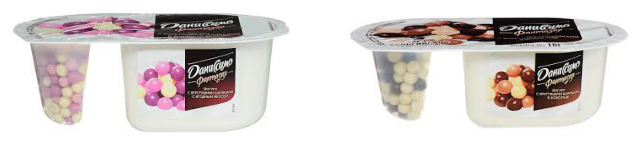

In [16]:
figsize = (8, 8)
fig=plt.figure(figsize=figsize)
columns = len(class_images)
for i, class_image in enumerate(class_images):
    fig.add_subplot(1, columns, i + 1)
    plt.imshow(class_image)
    plt.axis('off')


Show fixed number of detections that are above a certain threshold. Yellow rectangles show detection boxes. Each box has a class label and the detection scores (the higher the better the detection). Red parallelograms illustrate the affine transformations that align class images to the input image at the location of detection.

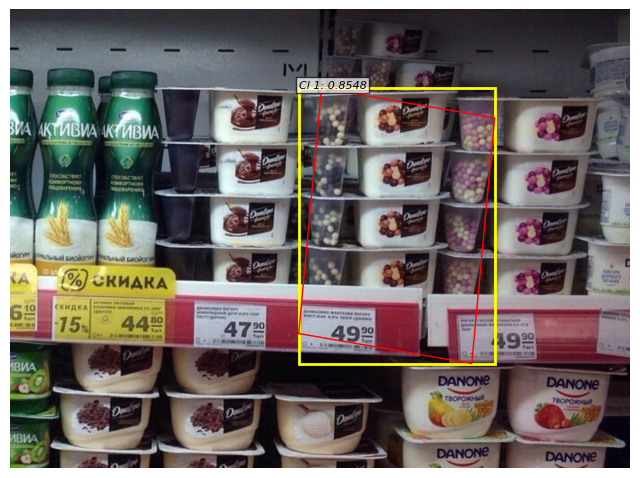

(tensor([[ 811.1151,  221.3082, 1362.0203,  995.6860]]),
 tensor([1]),
 tensor([0.8548]))

In [21]:
plt.rcParams["figure.figsize"] = figsize
cfg.defrost()
cfg.visualization.eval.max_detections = 1
cfg.visualization.eval.score_threshold = float("-inf")
cfg.freeze()
visualizer.show_detections(boxes, input_image,
                           cfg.visualization.eval)